This notebook is a prototype for modifying the pretrained MobileNetV2 model to classify imagery of penguin colonies found in Antarctica. The model was trained on a kaggle image classification dataset found here: https://www.kaggle.com/c/aerial-cactus-identification/overview

The penguin imagery is sourced from Michelle LaRue's data collection for her ongoing penguin study. 

TensorFlow & keras API's are used throughout this notebook.



# Install Dependencies

In [ ]:
# Setup Kaggle API
!pip install tensorflow_io

# The training dataset will be downloaded from Kaggle 
!pip install kaggle

In [ ]:
import tensorflow as tf
import tensorflow_io as tfi
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

print(tf.__version__)

2.7.0


# Download data from Kaggle

The following shows 3 ways to access the kaggle dataset.

Method 1:

Set up your Kaggle API Token at https://www.kaggle.com/account. From the site header:
- click on your user profile picture
- then “My Account”
- scroll down to the page labelled API
- click “Create New API Token” 
- find download authentication token & move to folder storing data

Your token should be protected either in commond line with: 
chmod 600 ~/.kaggle/kaggle.json

or by exporting your Kaggle username and token to the environment:

export KAGGLE_USERNAME=datadinosaur
export KAGGLE_KEY=xxxxxxxxxxxxxx

https://github.com/Kaggle/kaggle-api#api-credentials

In [ ]:
# Create directory to store dataset

!mkdir -p ~/.kaggle                                               
!cp kaggle.json ~/.kaggle/

# This hides your API key
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Search cactus datasets
!kaggle datasets list -s cactus

ref                                                 title                                   size  lastUpdated          downloadCount  
--------------------------------------------------  -------------------------------------  -----  -------------------  -------------  
irvingvasquez/cactus-aerial-photos                  Cactus Aerial Photos                    53MB  2019-02-21 18:41:06           1164  
moltean/fruits                                      Fruits 360                               1GB  2021-09-12 19:19:48          81977  
jacky5112/aerialcactusidentification                aerial-cactus-identification            97MB  2019-03-15 19:39:12            134  
olgabelitskaya/quick-draw-images-from-key-points-2  Quick, Draw! Images from Key Points 2  375MB  2020-07-25 06:49:41             10  
kabilan45/aerial-cactus                             aerial cactus                           85KB  2019-06-15 14:55:38              5  
mmoreaux/caltech256                                 cal

In [ ]:
# Download directly from kaggle & unzip
!kaggle datasets download irvingvasquez/cactus-aerial-photos 

 93% 49.0M/52.7M [00:01<00:00, 47.3MB/s]
100% 52.7M/52.7M [00:01<00:00, 51.8MB/s]


In [ ]:
!unzip /content/sample_data/kaggle/cactus-aerial-photos.zip -d data

Archive:  /content/sample_data/kaggle/cactus-aerial-photos.zip
replace data/training_set/training_set/cactus/cactus_0028_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Method 2:

In [ ]:
# This allows you to directly import files into colab.
# Use this option when you have the data locally. 
# This is stored as a session file which is deleted after 12 hours.

from google.colab import files 
files.upload()

Saving archive.zip to archive.zip


Method 3:

In [ ]:
# Mount data direct from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Sources:

https://www.kaggle.com/docs/api

https://towardsdatascience.com/downloading-kaggle-datasets-directly-into-google-colab-c8f0f407d73a

https://medium.com/css-knust/how-to-download-kaggle-datasets-directly-in-colab-bcc1a3192c5e

In [ ]:
os.mkdir('/content/sample_data/kaggle')
os.mkdir('/content/sample_data/kaggle/cacti_image')

In [ ]:
# Split data into training & testing

# Inspect Data

In [ ]:
# See the data structure
train_csv = pd.read_csv('train.csv')
print(train_csv.describe())
print(train_csv.head())

             label        0_0_R  ...      31_31_G      31_31_B
count  2223.000000  2223.000000  ...  2222.000000  2222.000000
mean      0.744489     0.505171  ...     0.448548     0.462983
std       0.436246     0.143265  ...     0.131590     0.147121
min       0.000000     0.023529  ...     0.003922     0.000000
25%       0.000000     0.403922  ...     0.360784     0.368627
50%       1.000000     0.517647  ...     0.454902     0.470588
75%       1.000000     0.603922  ...     0.537255     0.555882
max       1.000000     1.000000  ...     0.972549     0.996078

[8 rows x 3073 columns]
                                     id  label  ...   31_31_G   31_31_B
0  0004be2cfeaba1c0361d39e2b000257b.jpg      1  ...  0.431373  0.509804
1  000c8a36845c0208e833c79c1bffedd1.jpg      1  ...  0.431373  0.474510
2  000d1e9a533f62e55c289303b072733d.jpg      1  ...  0.494118  0.529412
3  0011485b40695e9138e92d0b3fb55128.jpg      1  ...  0.443137  0.517647
4  0014d7a11e90b62848904c1418fc8cf2.jpg      1  

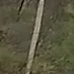

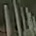

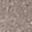

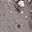

In [ ]:
# A quick peak at the data
display(Image('/content/sample_data/kaggle/data/training_set/training_set/cactus/cactus_0028_0.jpg'))
display(Image('/content/sample_data/kaggle/data/training_set/training_set/cactus/cactus_0028_148.jpg'))
display(Image('/content/sample_data/kaggle/data/training_set/training_set/no_cactus/Sinplanta.1009.jpg'))
display(Image('/content/sample_data/kaggle/data/training_set/training_set/no_cactus/Sinplanta.1252.jpg'))

# Preprocess Data

In [ ]:
# Read filenames from directory

import glob

labels = []

#img_dir = "/content/sample_data/kaggle/data/training_set/training_set/cactus"
img_dir = "drive/MyDrive/Penguin_Project/DATA/models/train/penguins"
filenames = glob.glob(img_dir+'/*.png')
for f in filenames:
    labels.append(1)

#img_dir = "/content/sample_data/kaggle/data/training_set/training_set/no_cactus"
img_dir = "drive/MyDrive/Penguin_Project/DATA/models/train/nopenguins"
filenames0 = glob.glob(img_dir+"/*.png")
for f in filenames0:
    labels.append(0)

filenames.extend(filenames0)


In [ ]:
# A quick check on file length
print(len(filenames))
print(len(labels))

1088
1088


In [ ]:
# Split the data into training & testing sets & verify length
train_filenames, val_filenames, train_labels, val_labels = train_test_split(filenames,
                                                                            labels,
                                                                            train_size=0.9,
                                                                            random_state=420)

num_train = len(train_filenames)
num_val = len(val_filenames)

print(num_train)
print(num_val)

979
109


In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(
  (tf.constant(train_filenames), tf.constant(train_labels))
)
val_data = tf.data.Dataset.from_tensor_slices(
  (tf.constant(val_filenames), tf.constant(val_labels))
)

In [ ]:
print(train_filenames)

['drive/MyDrive/Penguin_Project/DATA/models/train/nopenguins/AmandaBay_2010_101001000C4E2900_QB02_11840160.tif.png', 'drive/MyDrive/Penguin_Project/DATA/models/train/penguins/AmandaBay_2011_101001000E3D6400_QB02_00960096.tif.png', 'drive/MyDrive/Penguin_Project/DATA/models/train/penguins/AmandaBay_2012_103001001C946E00_WV02_18880384.tif.png', 'drive/MyDrive/Penguin_Project/DATA/models/train/nopenguins/AmandaBay_2011_101001000E3D6400_QB02_05760000.tif.png', 'drive/MyDrive/Penguin_Project/DATA/models/train/nopenguins/AmandaBay_2010_101001000C4E2900_QB02_04160160.tif.png', 'drive/MyDrive/Penguin_Project/DATA/models/train/penguins/AmandaBay_2012_103001001C946E00_WV02_15680384.tif.png', 'drive/MyDrive/Penguin_Project/DATA/models/train/penguins/AmandaBay_2012_103001001C946E00_WV02_13760576.tif.png', 'drive/MyDrive/Penguin_Project/DATA/models/train/penguins/AmandaBay_2012_103001001C946E00_WV02_19200384.tif.png', 'drive/MyDrive/Penguin_Project/DATA/models/train/nopenguins/AmandaBay_2011_101001

In [ ]:
IMAGE_SIZE = 96


def _parse_fn(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_png(image_string)
  image_normalized = (tf.cast(image_decoded, tf.float32)/127.5) - 1
  image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))
  return image_resized, label

In [ ]:
BATCH_SIZE = 32

train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_filenames), tf.constant(train_labels))).map(_parse_fn).shuffle(buffer_size=10000).batch(BATCH_SIZE)


val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), tf.constant(val_labels))).map(_parse_fn).batch(BATCH_SIZE)

# Define Model

In [ ]:
# Base model with MobileNetV2
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
print(IMG_SHAPE)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')
base_model.trainable = False

(96, 96, 3)


In [ ]:
# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [ ]:
learning_rate = 0.0001

model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    prediction_layer
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_max_pooling2d_4 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Train

In [ ]:
# Train the model with a small run
num_epochs = 2
steps_per_epoch = round(num_train)//BATCH_SIZE
val_steps = 10
model.fit(train_data.repeat(),
          epochs=num_epochs,
          steps_per_epoch = steps_per_epoch,
          validation_data=val_data.repeat(), 
          validation_steps=val_steps)

Epoch 1/2


InvalidArgumentError: ignored

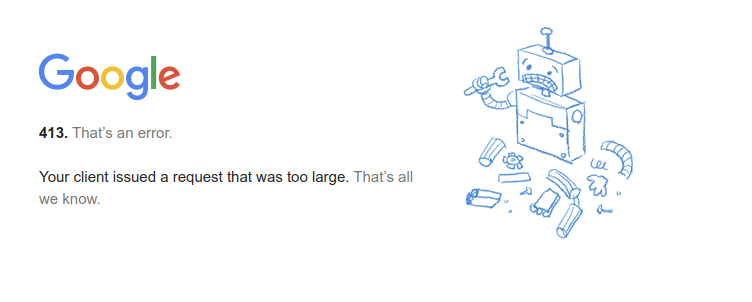

In [ ]:
# Save model weights
model.save_weights('weights_epoch_2.h5')

In [ ]:
# Visualize the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tune

In [ ]:
# Unfreeze all layers of MobileNetV2
base_model.trainable = True

# Refreeze base layers to fine-tune top layers
for layer in base_model.layers[:100]:
  layer.trainable =  False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=learning_rate/10),
              metrics=['accuracy'])
model.summary()

In [ ]:
# Fine tune top layers
fine_tune_epochs = 30
total_epochs =  num_epochs + fine_tune_epochs

history_fine = model.fit(train_data.repeat(), 
                         steps_per_epoch = steps_per_epoch,
                         epochs=total_epochs, 
                         initial_epoch = num_epochs,
                         validation_data=val_data.repeat(), 
                         validation_steps=val_steps)

In [ ]:
# Save fine-tuned model weights
model.save_weights('weights_epoch_50_finetuned.h5')

In [ ]:
# Get new results
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
# Visualize new results
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([num_epochs-1,num_epochs-1], 
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([num_epochs-1,num_epochs-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Train model with penguin data

Read in new penguin dataset to run with pretrained model. Tif files need to be converted to pngs.

In [ ]:
# Set the path to the penguin training images
data_path = 'drive/MyDrive/penguins_train'

# Get a list of image files
filenames = glob.glob(data_path+'/**/*.tif',recursive=True)

# Get the labels from the path names
labels = []
for f in filenames:
    if 'nopenguin' in f:
	    labels.append('nopenguin')
    else:
        labels.append('penguin')



In [ ]:
# Make a list for training data & labels
train_filenames, val_filenames, train_labels, val_labels = \
  train_test_split(filenames, labels, train_size=0.9, random_state=42)
